In [51]:
import itertools
import os
import pickle
import sys
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
from skimage import exposure
from skimage.registration import phase_cross_correlation
from sklearn import preprocessing

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Import path
from config import *
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [45]:
csv_file = data_meta / "all_info.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)

## Read masks image and corresponding intensity measurement

In [46]:
def get_masks(mask_folder):
    '''
    Function to get all mask from mask forlder
    '''
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tiff" in name:
                condition = name.split("_")[0]
                masks[condition] = masks.get(condition, {})
                filename = os.path.join(dirpath, name)
            if "cyto" in name:
                img = skimage.io.imread(filename)
                masks[condition]["cyto"] = img
            elif "nuclei" in name:
                img = skimage.io.imread(filename)
                masks[condition]["nuclei"] = img
    return masks

In [47]:
# Read mask image
masks = get_masks(data_mask)

## Create image based on intensity level of expression 

In [48]:
df_intensity = pd.read_csv(data_meta / 'measurements_intensity.csv')
markers = df_intensity.Marker.unique()

We have {{len(markers)}} markers (no including DAPI and cell segmentation markers) 

In [49]:
def create_expression_img(mask_cyto, mask_nuclei, df):
    markers = df.Marker.unique()
    imgs = []

    cell = np.zeros((mask_cyto.shape), dtype=np.uint8)
    nuclei = np.zeros((mask_cyto.shape), dtype=np.uint8)
    cyto = np.zeros((mask_cyto.shape), dtype=np.uint8)

    for label in range(1, mask_cyto.max()):
        # Check if cell has nuclei
        cell_mask = np.where(mask_cyto == label, 1, 0).astype(np.uint8)
        maski = cv2.bitwise_and(mask_nuclei, mask_nuclei, mask=cell_mask)

        # If no nuclei detected then pass
        if maski.max() == 0:
            continue

        # Link label accross cell, nuclei, cyto
        cell = np.where(mask_cyto == label, label, cell)
        nuclei = np.where(maski > 0, label, nuclei)
        maski = cv2.subtract(cell_mask, maski)
        cyto = np.where(maski > 0, label, cyto)

    for marker in markers:
        img = np.zeros((mask_cyto.shape), dtype=np.uint16)
        for label in df.Id.unique():
            row = df[(df.Id == label) & (df.Marker == marker)]
            nuclei_intensity = row['Nuclei mean_intensity'].item()
            cyto_intensity = row['Cell mean_intensity'].item()
            img = np.where(cyto == label, cyto_intensity, img)
            img = np.where(nuclei == label, nuclei_intensity, img)
        imgs.append(img)
    return imgs, markers

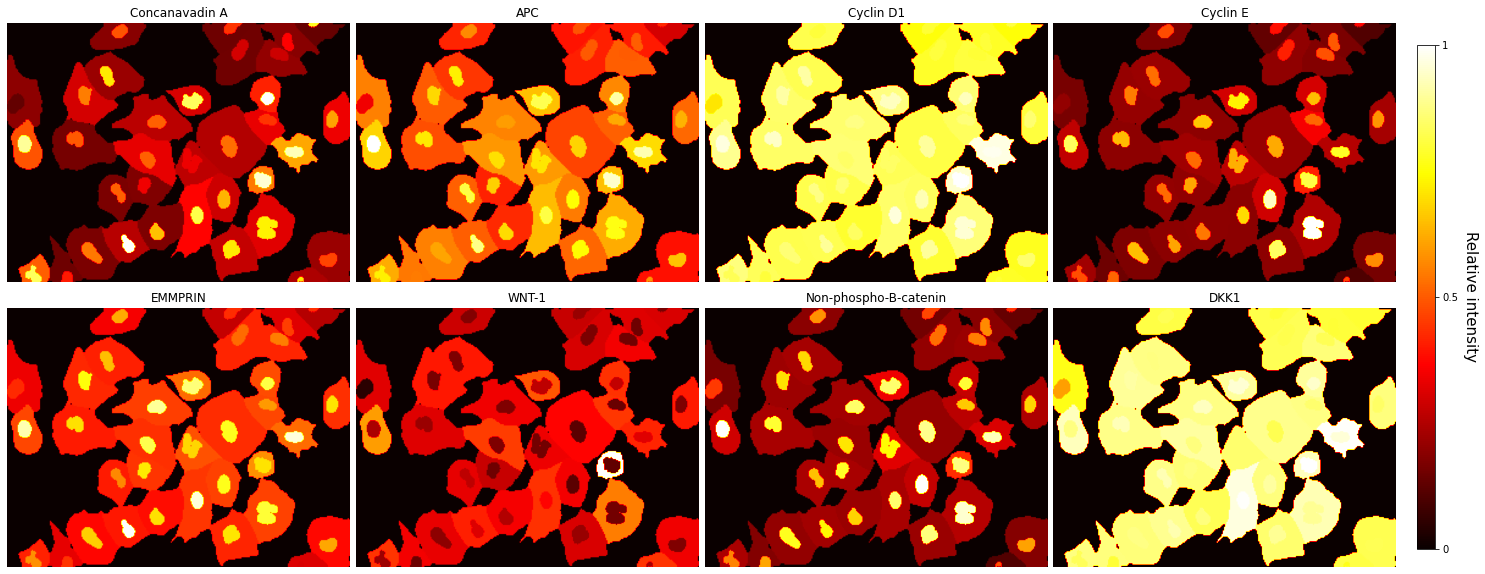

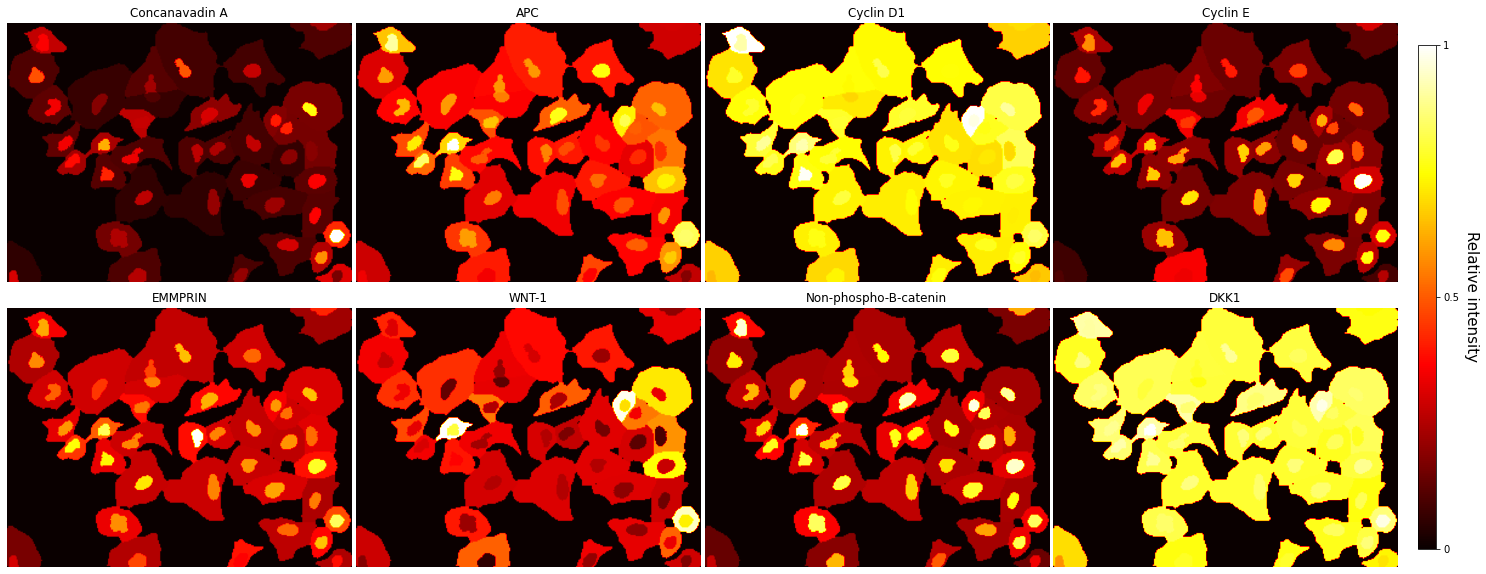

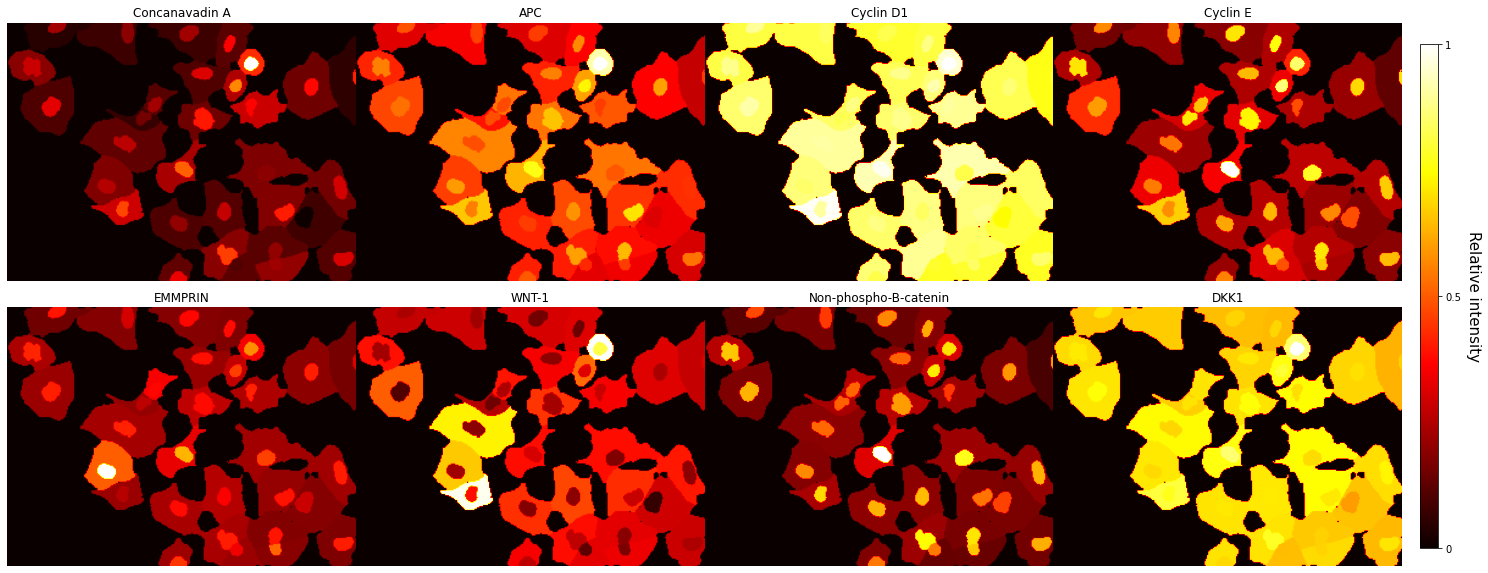

In [62]:
for idx, condition in enumerate(masks.keys()):
    mask_cyto = masks[condition]['cyto']
    mask_nuclei = masks[condition]['nuclei']
    df_intensity_subset = df_intensity[df_intensity.Condition == condition]
    imgs, markers = create_expression_img(
        mask_cyto, mask_nuclei, df_intensity_subset)

    fig, axs = plt.subplots(2, 4, figsize=(25, 10))
    axs = axs.flatten()
    for idx, ax in enumerate(axs):
        im = ax.imshow(imgs[idx], cmap='hot')
        ax.axis('off')
        ax.title.set_text(markers[idx])
    plt.subplots_adjust(wspace=0, hspace=0.1)

    # Add colobar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='hot', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, 3),
                        cax=cbar_ax)
    cbar.set_label('Relative intensity', rotation=270,
                   fontsize=15, labelpad=20)
    cbar.ax.set_yticklabels(['0', '0.5', '1'])

    # Save fig and show
    fig.savefig(condition+'_expression_level.png',
                bbox_inches='tight', dpi=100)
    plt.show()